In [1]:
import pandas as pd
import numpy as np
import swifter
import json
import math
import time
import re

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

from nltk.tokenize import RegexpTokenizer

In [2]:
labeled = pd.read_csv("labeled.csv", index_col=0)

selection_dct = dict(filter(lambda x: x[0] != -1 and x[1] > 5, labeled["Label"].value_counts().items()))
selection_a = labeled[labeled["Label"].apply(lambda x: x in selection_dct)]
selection_a.reset_index(inplace=True)

In [17]:
class ClusterBatch:
    def __init__(self, **kwargs):
        self._verbose = kwargs["verbose"]
        self._kwargs = kwargs
        if self._verbose:
            print("Initiated ClusterBatch:\n")
            print("\n".join(["-"+str(item)[1:-1] for item in kwargs.items()]))
            
    @classmethod
    def clean_tokens(self, raw_text:str, sub=[r"\\n"], min_length=1, drop_digits=False) -> [str]:
        tokenizer = RegexpTokenizer(r'\w+')
        result = raw_text.lower()
        [re.sub(sub, " ", result) for sub in sub]
        result = [
            token for token in tokenizer.tokenize(result)
            if len(token) >= min_length
        ]
        if drop_digits: return list(filter(lambda x: re.match(r"\w*\d\w*", x)==None, result))
        else: return result   
        
    @classmethod
    def generate_sparse_matrix(cls, tfidf:list(dict()), head:int=10):
        important = list(map(lambda x: dict(sorted(x.items(), key=lambda i: i[1])[::-1][:head]), tfidf))
        dimensions = set(np.concatenate(list(map(lambda x:list(x.keys()), important))))
        return np.array(list(map(lambda x: [x[idx] if idx in x else 0 for idx in dimensions], important)))

    @classmethod
    def calculate_cross_distance(cls, matrix):         
        non_zero_idxs_matrix = np.array([
            np.nonzero(arr)[0]
            for arr in matrix]) 
        
        def sparse_vector_distance(idx_a, idx_b):       
            idx_concat = np.concatenate((
                non_zero_idxs_matrix[idx_a],
                non_zero_idxs_matrix[idx_b]))
            return math.sqrt(sum(map(
                lambda x: (x[1]-x[0])**2, 
                zip(matrix[idx_a][idx_concat],
                    matrix[idx_b][idx_concat]))))
        
        length = len(matrix)
        return np.array([
            sparse_vector_distance(i, ii)
            for i in range(length)
            for ii in range(length)
        ]).reshape(length, length)
     
    def fit(self, raw_text_batch:[str]):
        start = time.time()
        if self._verbose: print("\nProcessing...")
        self._documents = raw_text_batch
        self._length = len(raw_text_batch)
        self._tokens = self._documents.apply(ClusterBatch.clean_tokens, drop_digits=True)
        if self._verbose: print(
            "Tokenized", len(self._tokens), "documents.")
            
        self._collection = set(np.concatenate(self._tokens))
        self._dictionary = {idx: word for idx, word in enumerate(sorted(self._collection))}
        self._dictionary_str = {word: idx for idx, word in self._dictionary.items()}
        if self._verbose: print(
            "Dict lookup generated with", len(self._collection), "unique words.\n")

        self._idxs = list(map(lambda x:
            list(map(lambda y: self._dictionary_str[y], x)),
            self._tokens))
        if self._verbose: print("Translated to indexes")
        self._counts = list(map(lambda x: 
            dict(zip(*np.unique(x, return_counts=True))),
            self._idxs))
        if self._verbose: print("Counting indexes\n")
        
        self._term_freq = list(map(lambda x: 
            {k:v/len(self._tokens[x[0]]) for k,v in x[1].items()},
            enumerate(self._counts)))
        if self._verbose: print("Calculated term frequencies")
            
        self._batch_freq = {idx: 
            sum(map(lambda doc: idx in doc, self._counts)) 
            for idx in self._dictionary}
        if self._verbose: print("Number of documents containing each term")
        
        self._dictionary_idf = {idx: 
            math.log10(self._length / self._batch_freq[idx]) 
            for idx in self._dictionary}
        if self._verbose: print("Inverse document frequency\n")
            
        self._tfidf = list(map(lambda x: {idx: 
            val * self._dictionary_idf[idx] 
            for idx, val in x.items()
            }, self._term_freq))        
        if self._verbose: 
            print("Preprocessing finish after",
                  int(time.time()-start),"seconds.\n")
            
        self._matrix = ClusterBatch.generate_sparse_matrix(self._tfidf)
        if self._verbose: print("Sparse matrix generated")
        
        self._cross_distance = ClusterBatch.calculate_cross_distance(self._matrix)
        if self._verbose: 
            print("Cross distance calculated\n")
            print("Fitting finished after", int(time.time()-start), "seconds.")
            
        return self
    
    def predict(self, perc):
        self._label = DBSCAN(eps=batch.percentile(perc), min_samples=3).fit_predict(batch._matrix)
        self._labels = dict(zip(*np.unique(self._label, return_counts=True)))
        print("Percentile:", self.percentile(perc))
        print(self._labels)
        idxs = [idx for idx, label in enumerate(self._label) if label==0]
        
        return self._label
    
    def percentile(self, cent:int):
        return np.percentile([val for val in np.concatenate(self._cross_distance) if val != 0], cent)
    
    def plot_distances(self):
        plt.hist(list(map(lambda x: np.median(x), self._cross_distance)), bins=20)
        plt.show()
        plt.plot(list(map(lambda x: np.median(x), sorted(self._cross_distance.T.flatten()))))
        plt.show()

Initiated ClusterBatch:

-'min_thresh', 0.0
-'max_thresh', 100
-'min_samples', 3
-'verbose', 1

Processing...
Tokenized 36 documents.
Dict lookup generated with 9444 unique words.

Translated to indexes
Counting indexes

Calculated term frequencies
Number of documents containing each term
Inverse document frequency

Preprocessing finish after 2 seconds.

Sparse matrix generated
Cross distance calculated

Fitting finished after 2 seconds.


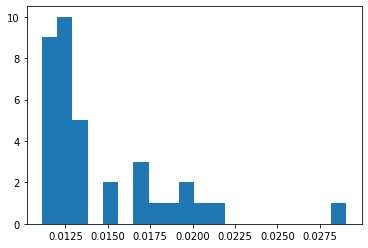

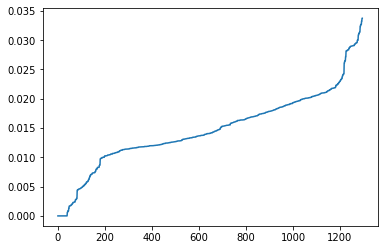

Percentile: 0.007926321049114211
{-1: 15, 0: 10, 1: 6, 2: 5}


In [18]:
batch = ClusterBatch(
    min_thresh=0.0, max_thresh=100,
    min_samples=3, verbose=1,
).fit(selection_a["Raw"])

batch.plot_distances()
label = batch.predict(10)

### Add recurrent